<a href="https://colab.research.google.com/github/monzzzz/AIMO-Competition/blob/main/AIMO_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download AIME Dataset**

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


train_dataset = pd.read_csv("/content/drive/MyDrive/AIMO Competition/train_dataset.csv")

eval_dataset = "/content/drive/MyDrive/AIMO Competition/eval_dataset.csv"
df = pd.read_csv(eval_dataset)

problem_set = []
for index, line in df.iterrows():
  if (index == 2):
    break
  problem_set.append(line.problem)

Mounted at /content/drive


In [29]:
train_dataset.head()

,id,problem,answer,solution
0,701410,"Let \$x\$, \$y\$ and \$z\$ all exceed \$1\$ an...",60,"The ic notation doesn't tell us much, so we'll..."
1,329536,"Let \$f(x)=|x-p|+|x-15|+|x-p-15|\$, where \$0 ...",15,=\nIt is best to get rid of the s first.\nUnde...
2,340414,What is the product of the s of the \$x^2 + ...,20,"If we were to expand by squaring, we would get..."
3,729586,A machine-shop cutting tool has the shape of a...,26,"Because we are given a right angle, we look fo..."
4,707900,Suppose that the sum of the squares of two com...,4,=\nOne way to solve this problem is by . We ha...


In [2]:
!pip install bitsandbytes
!pip install accelerate
!pip install --upgrade transformers
!pip install peft
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 11.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

# Deep Seek Math Model

In [3]:
# Load model directly
import torch
from transformers import (AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoConfig, set_seed, Trainer, TrainingArguments)

set_seed(42)

# Qlora
# quantization_config = BitsAndBytesConfig(
#     load_in_4bit = True, # load the model in 4 bit
#     bnb_4bit_quant_type="nf4", # quantisize in the normalize float 4
#     bnb_4bit_compute_dtype=torch.bfloat16, # type of the number used in the calculation
#     bnb_4bit_use_double_quant=True, # quantisize 2 times
# )

config = AutoConfig.from_pretrained(
    "deepseek-ai/deepseek-math-7b-instruct",
)
config.gradient_checkpointing = True

tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-math-7b-instruct")
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained("deepseek-ai/deepseek-math-7b-instruct", device_map="auto", torch_dtype="auto", config = config) # load with accelarate (device_map)
model.generation_config.pad_token_id = model.generation_config.eos_token_id
model.generation_config

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

GenerationConfig {
  "bos_token_id": 100000,
  "eos_token_id": 100001,
  "pad_token_id": 100001
}

# Train

In [24]:
import re
import peft
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from datasets import load_dataset, Dataset

def get_num_layers(model):
    numbers = set()
    for name, _ in model.named_parameters():
        for number in re.findall(r'\d+', name):
            numbers.add(int(number))
    return max(numbers)

def get_last_layer_linears(model):
    names = []

    num_layers = get_num_layers(model)
    for name, module in model.named_modules():
        if str(num_layers) in name and not "encoder" in name:
            if isinstance(module, torch.nn.Linear):
                names.append(name)
    return names

config = LoraConfig(
    r=20,
    lora_alpha=32,
    target_modules=get_last_layer_linears(model),
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

train_dataset.columns = [str(q).strip() for q in train_dataset.columns]
print(train_dataset)

data = Dataset.from_pandas(train_dataset)

model = prepare_model_for_kbit_training(model)

model = get_peft_model(model, config)

generation_config = model.generation_config
generation_config.max_new_tokens = 2048
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

# prompt = "Problem: " + df["problem"].values[0] + " ".strip()

# encoding = tokenizer(prompt, return_tensors="pt").to("cuda")

# # with torch.no_grad():
# #     outputs = model.generate(
# #         input_ids = encoding["input_ids"],
# #         attention_mask = encoding.attention_mask,
# #         generation_config = generation_config
# #     )

def generate_prompt(data):
  return f"Problem Statement: {data['problem']} Solution: {data['answer']} Explaination: {data['solution']}"

def tokenize_generated_prompt(data):
  full_prompt = generate_prompt(data)
  tokenized_full_prompt = tokenizer(full_prompt, truncation=True, padding=True, max_length=512)
  return tokenized_full_prompt

data = data.shuffle().map(tokenize_generated_prompt)


         id                                            problem  answer  \
0    701410  Let \$x\$, \$y\$ and \$z\$ all exceed \$1\$ an...      60   
1    329536  Let \$f(x)=|x-p|+|x-15|+|x-p-15|\$, where \$0 ...      15   
2    340414  What is the product of the  s of the  \$x^2 + ...      20   
3    729586  A machine-shop cutting tool has the shape of a...      26   
4    707900  Suppose that the sum of the squares of two com...       4   
..      ...                                                ...     ...   
948  104697  A large urn contains \$100\$ balls, of which \...      50   
949   74094  Carlos took \$70\%\$ of a whole pie. Maria too...      20   
950  906006  For each real number \$a\$ with \$0 \leq a \le...       2   
951  944040  The sequence \$a_0,a_1,a_2,\cdots\$ is a stric...      12   
952  327349  Let \$ f(n) = \left( \frac{-1+i\sqrt{3}}{2} \r...       2   

                                              solution  
0    The ic notation doesn't tell us much, so we'll...

Map:   0%|          | 0/953 [00:00<?, ? examples/s]

In [28]:
print(data["problem"][0])

Square \$AIME\$ has sides of length \$10\$ units.  Isosceles triangle \$GEM\$ has base \$EM\$, and the area common to triangle \$GEM\$ and square \$AIME\$ is \$80\$ square units.  Find the length of the altitude to \$EM\$ in \$\triangle GEM\$.


In [5]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.7 MB/s eta 0:00:00


In [6]:
import wandb
wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
wandb.init(project="Fine Tuning Deepseek-Math")

wandb: Currently logged in as: elmond-pattanan (monzzz). Use `wandb login --relogin` to force relogin


In [32]:
!pip install transformers --upgrade
!pip install matplotlib

In [53]:
import transformers

training_args = transformers.TrainingArguments(
    per_device_train_batch_size = 5,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    learning_rate=1e-3,
    fp16 = True,
    output_dir="checkpoints",
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.01,
    logging_steps=5
)

train_dateset = data.select(list(range(800)))
eval_dataset = data.select(list(range(801, 953)))

trainer = transformers.Trainer(
    model = model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

model.config.use_cache = False
trainer.train()

KeyError: 226

ValueError: x and y must have same first dimension, but have shapes (47,) and (0,)

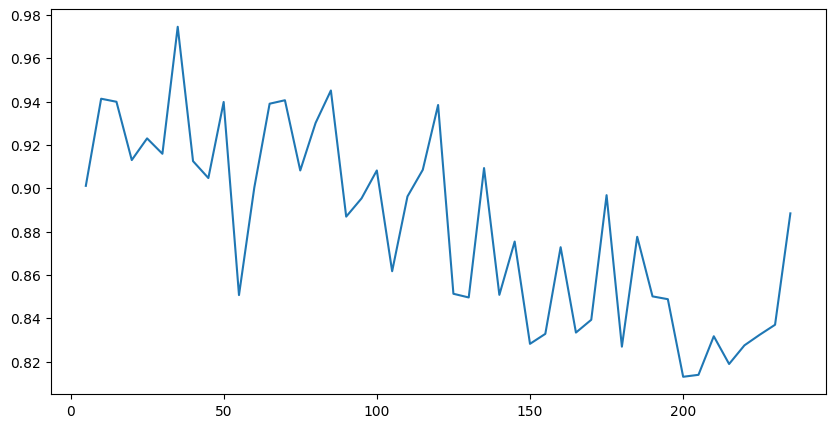

In [43]:
import matplotlib.pyplot as plt

training_logs = trainer.state.log_history

train_loss = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if 'eval_loss' in log]

steps = [log['step'] for log in training_logs if 'step' in log]

steps = steps[:47]

plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label="Train Loss")
plt.plot(steps, eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
!pip install numba

In [ ]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [10]:
model.save_pretrained("/content/drive/MyDrive/AIMO Competition/model")
merged_model = model.merge_and_unload()

In [66]:
device

NameError: name 'device' is not defined

In [63]:
def predict(model, tokenizer, ps):
  ans = []
  for problem in ps:
    # Tokenize the problem and return tensor in the PyTorch format
    input = tokenizer(problem, return_tensors="pt")

    # Move the input tensor to the same device as the model
    input = input.to(model.device)

    # Generate output from the model
    generate_id = model.generate(input["input_ids"], max_new_tokens=200, pad_token_id=tokenizer.eos_token_id)

    # Decode the output tokens
    result = tokenizer.decode(generate_id[0], skip_special_tokens=True)

    ans.append(result)
  return ans


In [64]:
print(problem_set[0])

Let $k, l > 0$ be parameters. The parabola $y = kx^2 - 2kx + l$ intersects the line $y = 4$ at two points $A$ and $B$. These points are distance 6 apart. What is the sum of the squares of the distances from $A$ and $B$ to the origin?


In [65]:
ans = predict(merged_model, tokenizer, problem_set)
print(ans)

['Let $k, l > 0$ be parameters. The parabola $y = kx^2 - 2kx + l$ intersects the line $y = 4$ at two points $A$ and $B$. These points are distance 6 apart. What is the sum of the squares of the distances from $A$ and $B$ to the origin?\n\\$\\textbf{(A)}\\ 100\\qquad\\textbf{(B)}\\ 120\\qquad\\textbf{(C)}\\ 140\\qquad\\textbf{(D)}\\ 160\\qquad\\textbf{(E)}\\ 180\\$ Solution: 2 Explaination: =\nLet the two points be \\$(x_1,4)\\$ and \\$(x_2,4)\\$\nThen \\$k(x_1)^2-2k(x_1)+l=4\\$ and \\$k(x_2)^2-2k(x_2)+l=4\\$\n\\$k(x_1)^2-2k(x_1)+l=k(x_2)^2-2k(x_2)+l\\$\n\\$k(x_1)^2-2k(x_1)=k(x_2)^2-2k(x_2)\\$\n\\$k', 'Each of the three-digits numbers $111$ to $999$ is coloured blue or yellow in such a way that the sum of any two (not necessarily different) yellow numbers is equal to a blue number. What is the maximum possible number of yellow numbers there can be?\n\\$\\textbf{(A)}\\ 100 \\qquad \\textbf{(B)}\\ 111 \\qquad \\textbf{(C)}\\ 121 \\qquad \\textbf{(D)}\\ 131 \\qquad \\textbf{(E)}\\ 141\\$ S

In [68]:
problem_set[0]

'Let $k, l > 0$ be parameters. The parabola $y = kx^2 - 2kx + l$ intersects the line $y = 4$ at two points $A$ and $B$. These points are distance 6 apart. What is the sum of the squares of the distances from $A$ and $B$ to the origin?'

In [67]:
ans[0]

'Let $k, l > 0$ be parameters. The parabola $y = kx^2 - 2kx + l$ intersects the line $y = 4$ at two points $A$ and $B$. These points are distance 6 apart. What is the sum of the squares of the distances from $A$ and $B$ to the origin?\n\\$\\textbf{(A)}\\ 100\\qquad\\textbf{(B)}\\ 120\\qquad\\textbf{(C)}\\ 140\\qquad\\textbf{(D)}\\ 160\\qquad\\textbf{(E)}\\ 180\\$ Solution: 2 Explaination: =\nLet the two points be \\$(x_1,4)\\$ and \\$(x_2,4)\\$\nThen \\$k(x_1)^2-2k(x_1)+l=4\\$ and \\$k(x_2)^2-2k(x_2)+l=4\\$\n\\$k(x_1)^2-2k(x_1)+l=k(x_2)^2-2k(x_2)+l\\$\n\\$k(x_1)^2-2k(x_1)=k(x_2)^2-2k(x_2)\\$\n\\$k'

In [14]:
def answer_validation(ans):
  out = []
  start = False
  end = False
  for l in reversed(list(answer)):
    if l in '0123456789' and not end:
      start = True
      out.append(l)
    else:
      if start:
        end = True
  out = reversed(out)
  return ''.join(out)

In [18]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=16d0b741f081ea144f7716c2cdca1a75d7923dbc7d173c84e07f11994f35d0e3
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [23]:
import re
from pylatexenc.latex2text import LatexNodes2Text

answer_list = []
for index, sans in enumerate(ans):
  # print(f"problem {index + 1}" + "\n")
  # print(sans[0])
  # matching = re.search(r'\{(.+?)\}', sans[0])
  answer_list.append(sans[0])

for answer_nums,answer in enumerate(answer_list):
  result = tokenizer.decode(answer, skip_special_tokens=True)
  print(result + "/n")
  text = LatexNodes2Text().latex_to_text(result)
  print(text + "\m")
  # index = 0;
  # target = "boxed{"
  # nums_answer = ""
  # for string_index, i in enumerate(result):
  #   if (i == target[index]):
  #     index+=1
  #     if (index == 5):
  #       nums_index = 2
  #       while (result[string_index + nums_index] != '}'):
  #         nums_answer  = nums_answer + result[string_index + nums_index]
  #         nums_index+=1
  #       index = 0
  #   else:
  #     index= 0
  # if (nums_answer == ""):
  #   print(f"problem {answer_nums+1}: " + "couldn't find an answer")
  # else:
  #   print(f"problem {answer_nums+1}: " + nums_answer)

Problem Statement: Let \$a_1, a_2, a_3, \ldots, a_{100}\$ be an arithmetic sequence with \$a_1 = 100\$ and \$a_{100} = 1000\$. Find the sum of the terms in the arithmetic sequence.
\$\textbf{(A)}\ 101000 \qquad\textbf{(B)}\ 1010000 \qquad\textbf{(C)}\ 10100000 \qquad\textbf{(D)}\ 101000000 \qquad\textbf{(E)}\ 1010000000\$ Solution: 100 Explaination: =
Let \$a_1, a_2, a_3, \ldots, a_{100}\$ be an arithmetic sequence with \$a_1 = 100\$ and \$a_{

Problem Statement: Let $a_1, a_2, a_3, …, a_100$ be an arithmetic sequence with $a_1 = 100$ and $a_100 = 1000$. Find the sum of the terms in the arithmetic sequence.
$(A) 101000     (B) 1010000     (C) 10100000     (D) 101000000     (E) 1010000000$ Solution: 100 Explaination: =
Let $a_1, a_2, a_3, …, a_100$ be an arithmetic sequence with $a_1 = 100$ and $a_

Problem Statement: Let \$a_1, a_2, a_3, \ldots, a_{100}\$ be an arithmetic sequence with \$a_1 = 100\$ and \$a_{100} = 1000\$. Find the sum of the terms in the arithmetic sequence.
\$\textbf

In [ ]:
git